In [10]:
#importing the libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from vacances_scolaires_france import SchoolHolidayDates
import sys
from impyute.imputation.cs import mice
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
#pip install vacances-scolaires-france
#pip3 install impyute
# my fonctions
def conv(data):
    data["date"] = data.timestamp.apply(lambda x : x.split('T')[0])
    data["datetime_perso"] = data.timestamp.apply(lambda x : get_format_the_date(x))
    data['year']=data['datetime_perso'].dt.year
    data['month']=data['datetime_perso'].dt.month
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['hours'] = data['timestamp'].dt.hour
    return data

## get season
def get_season(doy):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if doy in spring:
        season = 'spring'
    elif doy in summer:
      season = 'summer'
    elif doy in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

## verifie si jour ferie
def easter_date(year):
    a = year // 100
    b = year % 100
    c = (3 * (a + 25)) // 4
    d = (3 * (a + 25)) % 4
    e = (8 * (a + 11)) // 25
    f = (5 * a + b) % 19
    g = (19 * f + c - e) % 30
    h = (f + 11 * g) // 319
    j = (60 * (5 - d) + b) // 4
    k = (60 * (5 - d) + b) % 4
    m = (2 * j - k - g + h) % 7
    n = (g - h + m + 114) // 31
    p = (g - h + m + 114) % 31
    day = p + 1
    month = n
    return datetime(year, month, day)

def is_ferie(the_date):
    year = the_date.year
    easter = easter_date(year)
    days = [
        datetime(year, 1, 1),  # Premier de l'an
        easter + timedelta(days=1),  # Lundi de Pâques
        datetime(year, 5, 1),  # Fête du Travail
        datetime(year, 5, 8),  # Victoire de 1945
        easter + timedelta(days=39),  # Ascension
        easter + timedelta(days=49),  # Pentecôte
        datetime(year, 7, 14),  # Fête Nationale
        datetime(year, 8, 15),  # Assomption
        datetime(year, 11, 1),  # Toussaint
        datetime(year, 11, 11),  # Armistice 1918
        datetime(year, 12, 25),  # Noël
    ]
    return the_date in days

def get_format_the_date(timestamp):
    do = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%f')
    d5 = do.replace(minute=0, hour=0, second=0, microsecond=0).isoformat(' ')
    the_date = datetime.strptime(d5, "%Y-%m-%d %H:%M:%S")
    return the_date

def business_day(timestamp):
    if not is_ferie(timestamp) and timestamp.isoweekday() not in [6, 7]:
        return True
    else:
        return False
    
  

In [11]:
def processing(dataInt):
    ## missing value
    df = dataInt.copy()
    #df_num = df.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    #df_NonNum = df.select_dtypes(include=[np.object])
    imputed_training_mice = mice(df.values)
    data_mice = pd.DataFrame(imputed_training_mice, columns = df.columns, index = list(df.index.values))
   # dClean = data_mice.join(df_NonNum)
    ## drop variable inutile
    #d_tr = dClean.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    ## create extra attribute
    #conv(d_tr)
    #d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
    ## create season and rangeInYear
    #s = pd.to_datetime(pd.Series(d_tr['timestamp']))
    #d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
    #create jours working days
   # d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
    #Is it an holiday for zone A, B or C?
    #d = SchoolHolidayDates()
    #d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
    #d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
    #dataInt1 = d_tr.drop(['rangeInYear', 'datetime_perso', 'date', 'timestamp'], axis=1)
    return (data_mice)  


In [12]:
# creere un je
dataInt_raw = pd.read_csv('./data_set1/input_training_ssnsrY0.csv', parse_dates=['timestamp'], index_col='timestamp')
dataOut_raw = pd.read_csv('./data_set1/output_training_Uf11I9I.csv')
dataInt_raw.head()
dataInt_raw.columns
#----------------------


Index(['ID', 'temp_1', 'temp_2', 'mean_national_temp', 'humidity_1',
       'humidity_2', 'loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2',
       'loc_secondary_3', 'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3'],
      dtype='object')

In [13]:
dataInt = dataInt_raw.loc[:, ['temp_1', 'temp_2','mean_national_temp', 'humidity_1', 'humidity_2', 
                              'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']]
dataOut = dataOut_raw.drop(['ID'], axis=1)
dataInt.columns


Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3'],
      dtype='object')

In [14]:
dataInt.dtypes
dataInt.index.dtype
dataInt.index = pd.to_datetime(dataInt.index)
dataInt.index

DatetimeIndex(['2016-11-01 00:00:00', '2016-11-01 01:00:00',
               '2016-11-01 02:00:00', '2016-11-01 03:00:00',
               '2016-11-01 04:00:00', '2016-11-01 05:00:00',
               '2016-11-01 06:00:00', '2016-11-01 07:00:00',
               '2016-11-01 08:00:00', '2016-11-01 09:00:00',
               ...
               '2017-10-31 14:00:00', '2017-10-31 15:00:00',
               '2017-10-31 16:00:00', '2017-10-31 17:00:00',
               '2017-10-31 18:00:00', '2017-10-31 19:00:00',
               '2017-10-31 20:00:00', '2017-10-31 21:00:00',
               '2017-10-31 22:00:00', '2017-10-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8760, freq=None)

temp_1                     0
temp_2                     0
mean_national_temp         0
humidity_1                 0
humidity_2                 0
consumption_secondary_1    0
consumption_secondary_2    0
consumption_secondary_3    0
dtype: int64

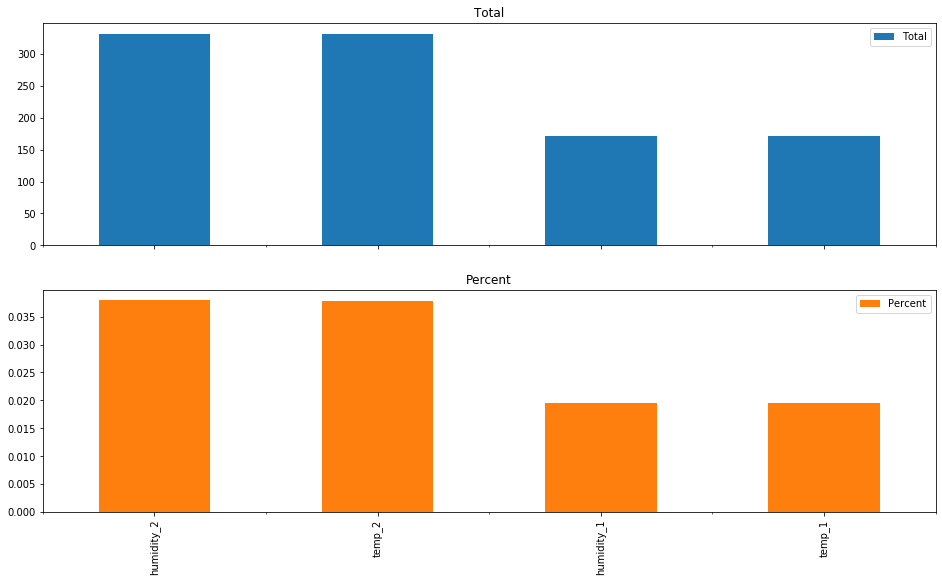

In [15]:
dataInt.dtypes
dataInt.index.dtype
dataInt.index = pd.to_datetime(dataInt.index)
dataInt.index
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    missing_data.plot.bar(subplots=True, figsize=(16,9))
list_and_visualize_missing_data(dataInt)

processing(dataInt)
dataInt[dataInt.isnull()].count()

In [16]:
print(dataInt.describe())

            temp_1       temp_2  mean_national_temp   humidity_1   humidity_2  \
count  8589.000000  8429.000000         8760.000000  8589.000000  8428.000000   
mean     11.402771    15.086274           13.173858    77.351496    63.443284   
std       7.049919     8.463627            6.474700    16.638173    21.900343   
min      -5.700000    -7.200000           -1.800000    21.000000    12.000000   
25%       6.100000     9.000000            8.200000    66.000000    46.000000   
50%      11.200000    14.500000           12.800000    81.000000    65.000000   
75%      16.400000    21.000000           18.700000    91.000000    83.000000   
max      33.600000    39.300000           28.300000   100.000000    99.000000   

       consumption_secondary_1  consumption_secondary_2  \
count              8760.000000              8760.000000   
mean                203.025114               123.581735   
std                  69.792811                65.036526   
min                  84.000000    

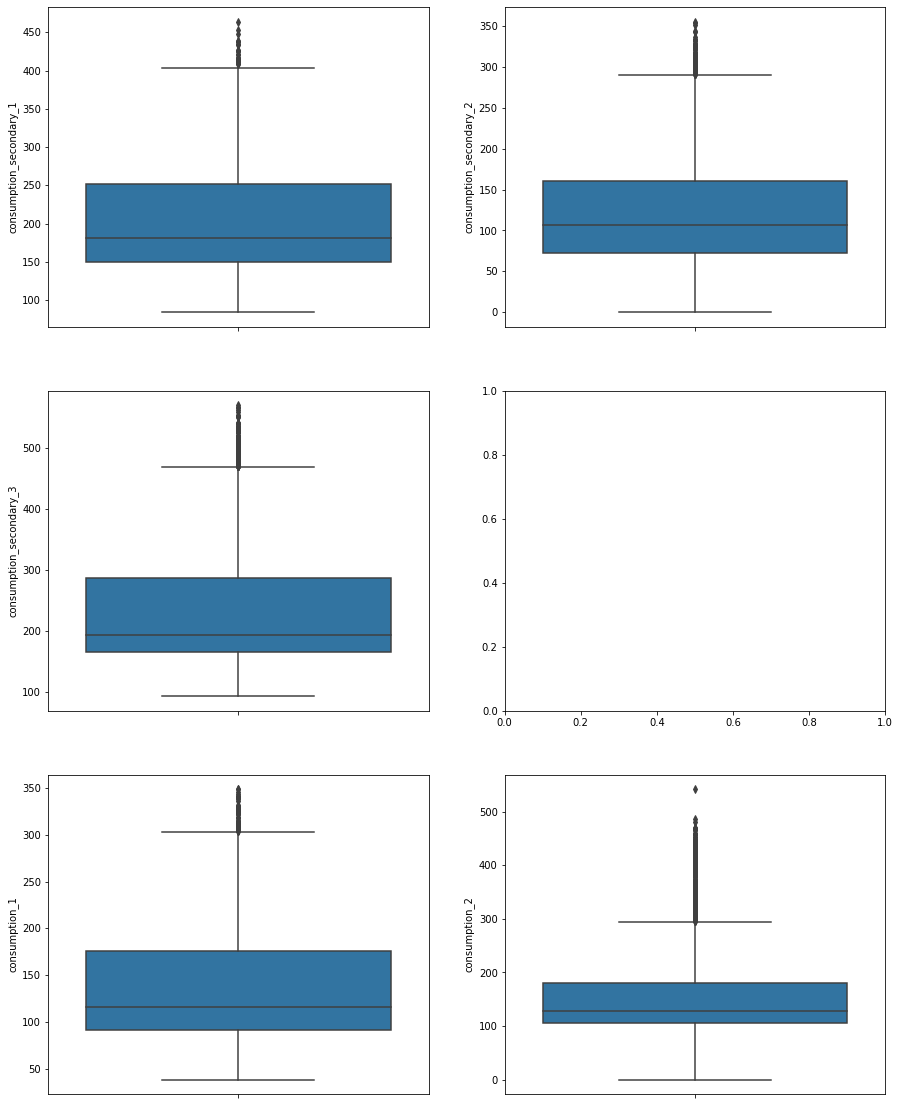

In [22]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 20)
sns.boxplot(data=dataInt,y="consumption_secondary_1",orient="v",ax=axes[0][0])
sns.boxplot(data=dataInt,y="consumption_secondary_2",orient="v",ax=axes[0][1])
sns.boxplot(data=dataInt,y="consumption_secondary_3",orient="v",ax=axes[1][0])
sns.boxplot(data=dataOut,y="consumption_1",orient="v",ax=axes[2][0])
sns.boxplot(data=dataOut,y="consumption_2",orient="v",ax=axes[2][1])

In [238]:
processing(dataInt, dataTest)

(        ID              timestamp  temp_1  temp_2  mean_national_temp  \
 0        0  2016-11-01T00:00:00.0     8.3     NaN                11.1   
 1        1  2016-11-01T01:00:00.0     8.0     NaN                11.1   
 2        2  2016-11-01T02:00:00.0     6.8     NaN                11.0   
 3        3  2016-11-01T03:00:00.0     7.5     NaN                10.9   
 4        4  2016-11-01T04:00:00.0     6.1     NaN                10.8   
 5        5  2016-11-01T05:00:00.0     5.4     NaN                10.7   
 6        6  2016-11-01T06:00:00.0     5.0     NaN                10.5   
 7        7  2016-11-01T07:00:00.0     5.1     NaN                10.2   
 8        8  2016-11-01T08:00:00.0     4.7     NaN                10.2   
 9        9  2016-11-01T09:00:00.0     5.5     NaN                10.3   
 10      10  2016-11-01T10:00:00.0     8.6     NaN                10.7   
 11      11  2016-11-01T11:00:00.0    10.4     NaN                11.4   
 12      12  2016-11-01T12:00:00.0    

In [241]:
dataInt.head()

,ID,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
0,0,2016-11-01T00:00:00.0,8.3,NaN,11.1,95.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168
1,1,2016-11-01T01:00:00.0,8.0,NaN,11.1,98.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,60,162
2,2,2016-11-01T02:00:00.0,6.8,NaN,11.0,97.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",142,60,164
3,3,2016-11-01T03:00:00.0,7.5,NaN,10.9,99.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",139,60,162
4,4,2016-11-01T04:00:00.0,6.1,NaN,10.8,98.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",154,60,164


In [243]:
dataOut.head()

,ID,consumption_1,consumption_2
0,0,100,93
1,1,101,94
2,2,100,96
3,3,101,95
4,4,100,100


In [242]:
dataTest.head()

,ID,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
0,8760,2017-11-01T00:00:00.0,6.5,7.1,8.8,91.0,82.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",190,126,177
1,8761,2017-11-01T01:00:00.0,6.8,7.0,8.7,89.0,87.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",189,116,172
2,8762,2017-11-01T02:00:00.0,6.8,6.3,8.7,88.0,91.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",195,117,175
3,8763,2017-11-01T03:00:00.0,5.8,5.8,8.6,90.0,93.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",197,115,171
4,8764,2017-11-01T04:00:00.0,5.0,5.6,8.5,90.0,94.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",198,115,174


In [244]:
#SPLIT
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)
for train_index, test_index in tscv.split(dataInt):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = dataInt.iloc[train_index, :], dataInt.iloc[test_index, :]
    y_train, y_test = dataOut.iloc[train_index, :], dataOut.iloc[test_index, :]
    
# jeu de donnees propres:
    # X-train et y_train pour faire le modele
    # X_test et y_test pour tester mon modele
    # dataTest pour la soumission 

TimeSeriesSplit(max_train_size=None, n_splits=10)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

In [240]:
## gerer les dummies et les variables num
Xtrain_new = d_tr.drop(['ID'], axis=1)
print(Xtrain_new.shape)
featuresObject = ['season', 'year', 'month', 'hours', 'is_business_day', 'is_holiday']
for var in featuresObject:
    Xtrain_new[var] = Xtrain_new[var].astype('category')
Xtrain_new.dtypes

(796, 14)


temp_1                      float64
temp_2                      float64
mean_national_temp          float64
humidity_1                  float64
humidity_2                  float64
consumption_secondary_1     float64
consumption_secondary_2     float64
consumption_secondary_3     float64
year                       category
month                      category
hours                      category
is_business_day            category
is_holiday                 category
season                     category
dtype: object

In [ ]:
col_name_train = [f for f in Xtrain_new.columns if Xtrain_new[f].dtype == float]
type(col_name_train)

In [ ]:
Xtrain_new[col_name_train].dtypes

In [119]:
numeric_features_train = Xtrain_new[col_name_train]
type(numeric_features_train)

pandas.core.frame.DataFrame

In [121]:
Xtrain_new[col_name_train].dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
dtype: object

In [139]:
# Les Num
ct_num = ColumnTransformer([
        ('stdScal', StandardScaler(), ['temp_1','temp_2','mean_national_temp','humidity_1',
         'humidity_2','consumption_secondary_1','consumption_secondary_2','consumption_secondary_3'])],
    remainder='passthrough')
X_tr = ct_num.fit_transform(numeric_features_train)
Xtrain_new[col_name_train] = pd.DataFrame(X_tr, columns=numeric_features_train.columns, index = list(X_train.index.values))




In [140]:
type(X_tr)

numpy.ndarray

In [141]:
Xtrain_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7964 entries, 0 to 7963
Data columns (total 14 columns):
temp_1                     7964 non-null float64
temp_2                     7964 non-null float64
mean_national_temp         7964 non-null float64
humidity_1                 7964 non-null float64
humidity_2                 7964 non-null float64
consumption_secondary_1    7964 non-null float64
consumption_secondary_2    7964 non-null float64
consumption_secondary_3    7964 non-null float64
year                       7964 non-null category
month                      7964 non-null category
hours                      7964 non-null category
is_business_day            7964 non-null category
is_holiday                 7964 non-null category
season                     7964 non-null category
dtypes: category(6), float64(8)
memory usage: 928.3 KB


In [142]:
type(Xtrain_new)

pandas.core.frame.DataFrame

In [143]:
## verifier les resultats de la sortie de X_tr
print(np.mean(X_tr,axis=0))### moyenne 
print(np.std(X_tr,axis=0,ddof=0)) ### ecart type

[ 1.14200741e-16 -1.14200741e-16  0.00000000e+00 -3.42602223e-16
  1.71301112e-16  1.14200741e-16 -2.85501853e-17 -5.71003705e-17]
[1. 1. 1. 1. 1. 1. 1. 1.]


In [144]:
# Gerer les variables categoriques
ct = ColumnTransformer([
        ('oh_enc', 
         OneHotEncoder(sparse=False), 
         [8,9,10,11,12,13]),])
d_1he = ct.fit_transform(Xtrain_new)
d_encoded_data = pd.DataFrame(d_1he, columns=ct.get_feature_names())
d_encoded_data.drop(['oh_enc__x0_2016', 'oh_enc__x1_1','oh_enc__x2_0', 'oh_enc__x3_0','oh_enc__x4_0', 'oh_enc__x5_fall'], inplace=True, axis=1)
df_concat = pd.concat([Xtrain_new.reset_index(drop=True), d_encoded_data.reset_index(drop=True)], axis=1)
df_concat.drop(['season', 'year', 'month', 'hours', 'is_business_day', 'is_holiday'], inplace=True, axis=1)
X_trained = df_concat[:dataInt.shape[0]]
X_trained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7964 entries, 0 to 7963
Data columns (total 47 columns):
temp_1                     7964 non-null float64
temp_2                     7964 non-null float64
mean_national_temp         7964 non-null float64
humidity_1                 7964 non-null float64
humidity_2                 7964 non-null float64
consumption_secondary_1    7964 non-null float64
consumption_secondary_2    7964 non-null float64
consumption_secondary_3    7964 non-null float64
oh_enc__x0_2017            7964 non-null float64
oh_enc__x1_2               7964 non-null float64
oh_enc__x1_3               7964 non-null float64
oh_enc__x1_4               7964 non-null float64
oh_enc__x1_5               7964 non-null float64
oh_enc__x1_6               7964 non-null float64
oh_enc__x1_7               7964 non-null float64
oh_enc__x1_8               7964 non-null float64
oh_enc__x1_9               7964 non-null float64
oh_enc__x1_11              7964 non-null float64
oh_enc__x1_

In [145]:
dI = X_test.copy()
## missing value
dI_num = dI.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
imputed_training_mice=mice(dI_num.values)
data_mice = pd.DataFrame(imputed_training_mice, columns=dI_num.columns, index = list(dI.index.values))
dI_NonNum = dI.select_dtypes(include=[np.object])
dClean = data_mice.join(dI_NonNum)


In [146]:

## drop variable inutile
d_tr = dClean.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
## create extra attribute

conv(d_tr)
d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
## create season and rangeInYear
s = pd.to_datetime(pd.Series(d_tr['timestamp']))
d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
#create jours working days
d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
# Is it an holiday for zone A, B or C?
d = SchoolHolidayDates()
d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
d_tr= d_tr.drop(['rangeInYear', 'datetime_perso', 'date', 'timestamp'], axis=1)
d_tr.info() #  A ENLEVER

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 15 columns):
ID                         796 non-null float64
temp_1                     796 non-null float64
temp_2                     796 non-null float64
mean_national_temp         796 non-null float64
humidity_1                 796 non-null float64
humidity_2                 796 non-null float64
consumption_secondary_1    796 non-null float64
consumption_secondary_2    796 non-null float64
consumption_secondary_3    796 non-null float64
year                       796 non-null int64
month                      796 non-null int64
hours                      796 non-null int64
is_business_day            796 non-null int64
is_holiday                 796 non-null int64
season                     796 non-null object
dtypes: float64(9), int64(5), object(1)
memory usage: 139.5+ KB


In [147]:
## gerer les dummies et les variables num
Xtest_new1 = d_tr.drop(['ID'], axis=1)
featuresObject = ['season', 'year', 'month', 'hours', 'is_business_day', 'is_holiday']
for var in featuresObject:
    Xtest_new1[var] = Xtest_new1[var].astype('category')
Xtest_new1.info()
Xtest_new = Xtest_new1.copy()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null float64
temp_2                     796 non-null float64
mean_national_temp         796 non-null float64
humidity_1                 796 non-null float64
humidity_2                 796 non-null float64
consumption_secondary_1    796 non-null float64
consumption_secondary_2    796 non-null float64
consumption_secondary_3    796 non-null float64
year                       796 non-null category
month                      796 non-null category
hours                      796 non-null category
is_business_day            796 non-null category
is_holiday                 796 non-null category
season                     796 non-null category
dtypes: category(6), float64(8)
memory usage: 101.9 KB


In [148]:
col_name_test = [f for f in Xtest_new.columns if Xtest_new[f].dtype == float]
type(col_name_test)

list

In [149]:
numeric_features_test = Xtest_new[col_name_test]
type(numeric_features_test)

pandas.core.frame.DataFrame

In [150]:
Xtest_new[col_name_test].dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
dtype: object

In [155]:
X_te = ct_num.fit(numeric_features_test)
Xtest_new[col_name_test] = pd.DataFrame(X_te, columns=numeric_features_test.columns, index = list(X_test.index.values))

type(X_te)

sklearn.compose._column_transformer.ColumnTransformer

In [156]:
Xtest_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null object
temp_2                     796 non-null object
mean_national_temp         796 non-null object
humidity_1                 796 non-null object
humidity_2                 796 non-null object
consumption_secondary_1    796 non-null object
consumption_secondary_2    796 non-null object
consumption_secondary_3    796 non-null object
year                       796 non-null category
month                      796 non-null category
hours                      796 non-null category
is_business_day            796 non-null category
is_holiday                 796 non-null category
season                     796 non-null category
dtypes: category(6), object(8)
memory usage: 61.9+ KB


In [157]:
print(type(X_te))
print(X_te[0])

<class 'sklearn.compose._column_transformer.ColumnTransformer'>


TypeError: 'ColumnTransformer' object is not subscriptable

In [154]:
numeric_features_test = scaler.transform(numeric_features_test.values)



NameError: name 'scaler' is not defined

In [109]:
# les num
X_tr_test = ct_num.fit(numeric_features_test)
Xtest_new[numeric_features_col_name_test] = pd.DataFrame(X_tr_test, columns=numeric_features_test.columns, index = list(X_test.index.values))
Xtest_new.info()
# Gerer les variables categoriques

NameError: name 'numeric_features_col_name_test' is not defined

In [110]:
Xtest_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null object
temp_2                     796 non-null object
mean_national_temp         796 non-null object
humidity_1                 796 non-null object
humidity_2                 796 non-null object
consumption_secondary_1    796 non-null object
consumption_secondary_2    796 non-null object
consumption_secondary_3    796 non-null object
year                       796 non-null category
month                      796 non-null category
hours                      796 non-null category
is_business_day            796 non-null category
is_holiday                 796 non-null category
season                     796 non-null category
dtypes: category(6), object(8)
memory usage: 61.9+ KB


In [42]:

d_1he_test = ct.fit(Xtest_new)

Xtest_new.info()
Xtrain_new.info()
d_encoded_data = pd.DataFrame(d_1he_test, columns=ct.get_feature_names(), index = list(X_test.index.values))
d_encoded_data.drop(['oh_enc__x0_2016', 'oh_enc__x1_1','oh_enc__x2_0', 'oh_enc__x3_0','oh_enc__x4_0', 'oh_enc__x5_fall'], inplace=True, axis=1)
df_concat = pd.concat([Xtest_new.reset_index(drop=True), d_encoded_data.reset_index(drop=True)], axis=1)
df_concat.drop(['season', 'year', 'month', 'hours', 'is_business_day', 'is_holiday'], inplace=True, axis=1)
X_test_trained = df_concat[:dataInt.shape[0]]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null object
temp_2                     796 non-null object
mean_national_temp         796 non-null object
humidity_1                 796 non-null object
humidity_2                 796 non-null object
consumption_secondary_1    796 non-null object
consumption_secondary_2    796 non-null object
consumption_secondary_3    796 non-null object
year                       796 non-null category
month                      796 non-null category
hours                      796 non-null category
is_business_day            796 non-null category
is_holiday                 796 non-null category
season                     796 non-null category
dtypes: category(6), object(8)
memory usage: 101.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null object
temp_2    

KeyError: "['oh_enc__x0_2016' 'oh_enc__x1_1'] not found in axis"

In [31]:
### POUR COMPRENDRE CE QUI SE PASSE A LA SORTIE DE STDSCALER

In [33]:
import pandas as pd
data = pd.DataFrame({'Name' : [3, 4,6], 'Age' : [18, 92,98], 'Weight' : [68, 59,49]})


In [34]:
data

,Name,Age,Weight
0,3,18,68
1,4,92,59
2,6,98,49


In [35]:
col_names = ['Name', 'Age', 'Weight']
features = data[col_names]

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [37]:
ct = ColumnTransformer([
        ('somename', StandardScaler(), ['Age', 'Weight'])
    ], remainder='passthrough')

In [42]:
ct.fit_transform(features)

array([[-1.41100443,  1.20270298,  3.        ],
       [ 0.62304092,  0.04295368,  4.        ],
       [ 0.78796352, -1.24565666,  6.        ]])

In [46]:
Z = ct.fit_transform(features)


In [47]:
ct.fit_transform(features)

array([[-1.41100443,  1.20270298,  3.        ],
       [ 0.62304092,  0.04295368,  4.        ],
       [ 0.78796352, -1.24565666,  6.        ]])

In [51]:
print(np.mean(Z,axis=0))
print(np.std(Z,axis=0,ddof=0))

[1.11022302e-16 2.96059473e-16 4.33333333e+00]
[1.         1.         1.24721913]
